This a project using CASjobs and SkyServer to take a look into DR18's dataset. 

In [2]:
# Imports
import SciServer
from SciServer import Authentication, LoginPortal, Config, CasJobs, SkyQuery, SciDrive, SkyServer, Files, Jobs
import os;
import pandas;
import sys;
import json;
from io import StringIO
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# PYTHON CONVENIENCE FUNCTIONS USEFUL FOR WORKING WITH CASJOBS
# Copied from "Example notebook: Search data with CasJobs"

def tables_formatted(tables):   # better formatted printing of a tables dictionary (output of get_tables)
# Returns the following information about the tables in your MyDB (as a Python dictionary object):
### Size: size of the table (in kB)
### Name: the name of the table
### Rows: the number of rows the table contains
### Date: the date of the table's creation, as the number of 10-microsecond intervals elapsed 1 AD

    import pandas
    from datetime import datetime
    
    tables = sorted(tables, key=lambda k: k['Name']) # alphabetize by table name
    
    for thistable in tables:
        print('Table name:\t',thistable['Name'])
        print('Rows:\t\t {:,.0f}'.format(thistable['Rows']))
        print('Size (kB):\t {:,.0f} '.format(thistable['Size']))

        cjCreateDate = thistable['Date']
        createsec = cjCreateDate / 10000000  # Divide by 10 million to get seconds elapsed since 1 AD
        firstday = datetime(1, 1, 1, 0, 0)   # Save 1 AD as "firstday"
        created = firstday + timedelta(seconds=createsec)  # Get calendar date on which table was created     
        print('Created time:\t',created.strftime('%Y-%m-%d %H:%M:%S'))
        print('\n')
        

def jobDescriber(jobDescription):
    # Prints the results of the CasJobs job status functions in a human-readable manner
    # Input: the python dictionary returned by getJobStatus(jobId) or waitForJob(jobId)
    # Output: prints the dictionary to screen with readable formatting
    import pandas
    
    if (jobDescription["Status"] == 0):
        status_word = 'Ready'
    elif (jobDescription["Status"] == 1):
        status_word = 'Started'
    elif (jobDescription["Status"] == 2):
        status_word = 'Cancelling'
    elif (jobDescription["Status"] == 3):
        status_word = 'Cancelled'
    elif (jobDescription["Status"] == 4):
        status_word = 'Failed'
    elif (jobDescription["Status"] == 5):
        status_word = 'Finished'
    else:
        status_word = 'Status not found!!!!!!!!!'

    print('JobID: ', jobDescription['JobID'])
    print('Status: ', status_word, ' (', jobDescription["Status"],')')
    print('Target (context being searched): ', jobDescription['Target'])
    print('Message: ', jobDescription['Message'])
    print('Created_Table: ', jobDescription['Created_Table'])
    print('Rows: ', jobDescription['Rows'])
    wait = pandas.to_datetime(jobDescription['TimeStart']) - pandas.to_datetime(jobDescription['TimeSubmit'])
    duration = pandas.to_datetime(jobDescription['TimeEnd']) - pandas.to_datetime(jobDescription['TimeStart'])
    print('Wait time: ',wait.seconds,' seconds')
    print('Query duration: ',duration.seconds, 'seconds')
        
print('Created functions')

In [5]:
# Authentication to access API

# Define login Name and password before running these examples
Authentication_loginName = 'diegomez17';
Authentication_loginPassword = 'V*km25!eBgjXLWV'

manualtoken = Authentication.login(Authentication_loginName, Authentication_loginPassword)
if (manualtoken):
    print("Logged in, happy viewing :)")
else:
    print("Oh no :(, manual login failed. Maybe try auto?)")

Logged in, happy viewing :)


/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/SciServer-2.1.0-py3.8.egg/SciServer/Authentication.py:118: Warning: Authentication token cannot be set to arbitary value when inside SciServer-Compute environment.


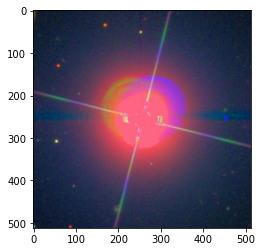

In [20]:
# Take a look at a galaxy from DR18
ra_center = 178.459548005224
dec_center = 0.552064259101041
pixel_scale = 0.37

# Plot galaxy
img = SkyServer.getJpegImgCutout(ra = ra_center, dec = dec_center, scale = pixel_scale)  
plt.imshow(img)

In [91]:
# Testing to see range of fields inside of DR18
queryMax="""
SELECT count(u)
FROM galaxy
WHERE clean=1 AND u>33
"""

results = CasJobs.executeQuery(queryMax, context="DR18")
results

,Column1
0,21


In [93]:
# Let's find some beautiful(purple) magnitudes and query a list. Bonus: Render an image of all of them
notCleanQuery="""
SELECT TOP 10 ra, dec, u
FROM galaxy
WHERE u>34.4
"""

cleanQuery="""
SELECT TOP 10 ra, dec, u
FROM galaxy
WHERE clean=1 AND u>33
"""

# Grab top 10 galaxies
notCleanResult = CasJobs.executeQuery(notCleanQuery, context="DR18")
notCleanResult

cleanResult = CasJobs.executeQuery(cleanQuery, context="DR18")
cleanResult

,ra,dec,u
0,236.306166,2.442872,33.29198
1,257.934449,41.722175,33.17496
2,223.915395,28.019131,33.08184
3,217.964326,24.985482,33.62706
4,357.794558,58.496715,33.18146
5,347.112539,74.155807,33.60400
6,346.939673,74.162780,33.70969
7,347.187486,74.186787,33.45640
8,182.780608,39.647601,33.56929
9,182.779693,39.675568,34.19885


Loaded image: 1
Loaded image: 2
Loaded image: 3
Loaded image: 4
Loaded image: 5
Loaded image: 6
Loaded image: 7
Loaded image: 8
Loaded image: 9
Loaded image: 10


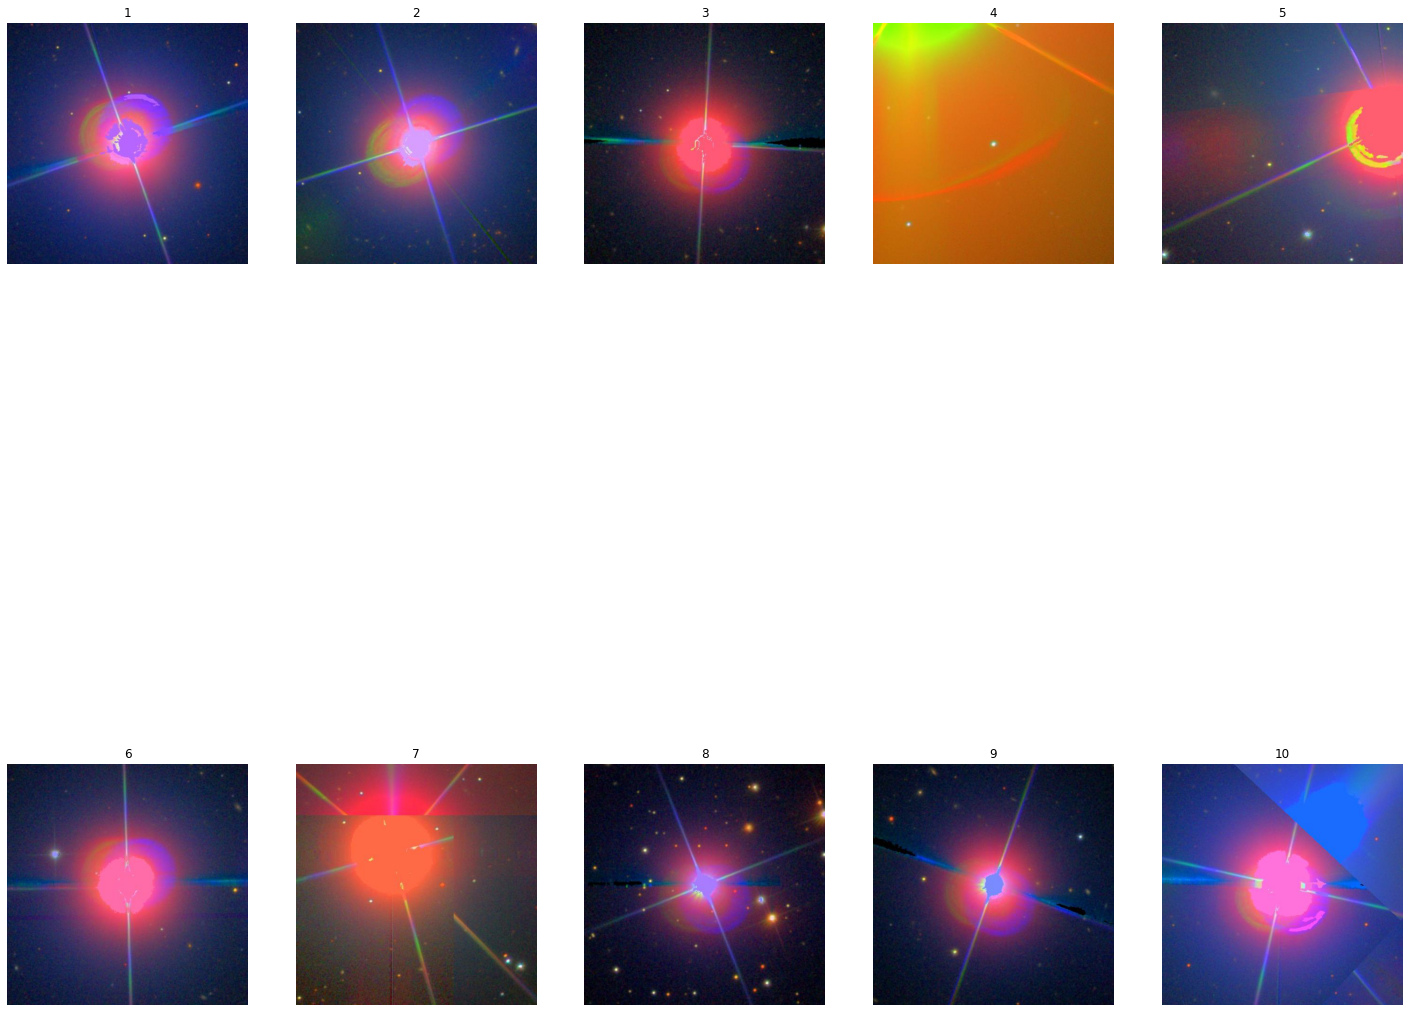

In [94]:
# Create not clean figure and populate w/ photos
fig = plt.figure(figsize=(25, 25))
counter = 1
for x in range(0,10):
    fig.add_subplot(2, 5, counter)
    current_ra = notCleanResult['ra'][x]
    current_dec = notCleanResult['dec'][x]
    plt.imshow(SkyServer.getJpegImgCutout(ra = current_ra, dec = current_dec, scale = .37))
    plt.axis('off')
    plt.title(counter)
    print("Loaded image:", counter)
    counter = counter + 1

plt.show()

Loaded image: 1
Loaded image: 2
Loaded image: 3
Loaded image: 4
Loaded image: 5
Loaded image: 6
Loaded image: 7
Loaded image: 8
Loaded image: 9
Loaded image: 10


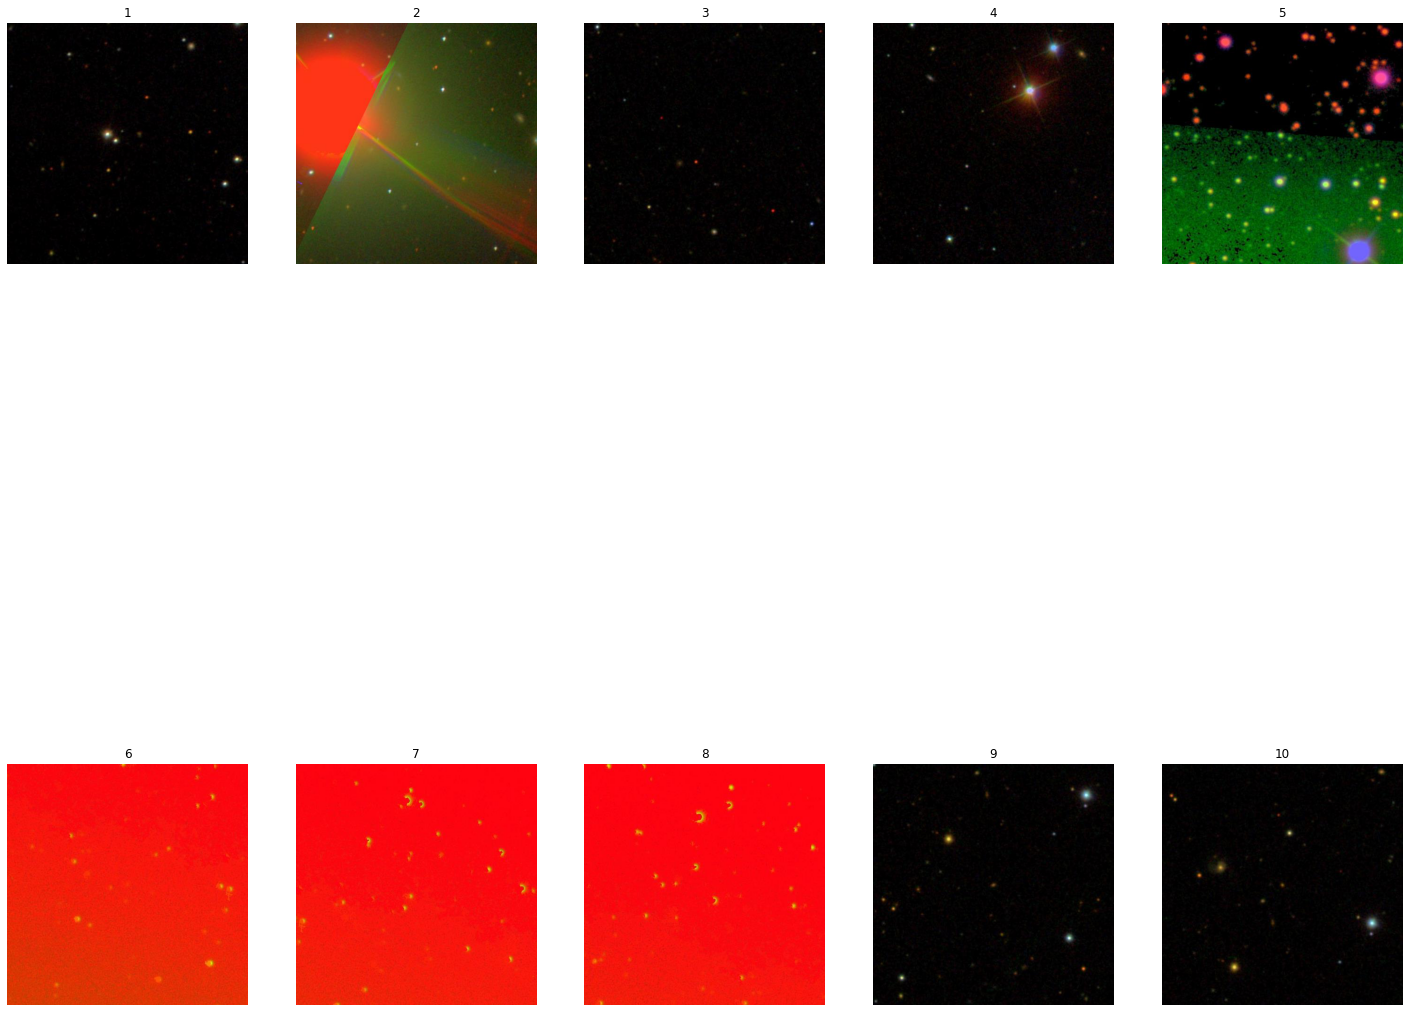

In [95]:
# Create clean figure and populate w/ photos
fig = plt.figure(figsize=(25, 25))
counter = 1
for x in range(0,10):
    fig.add_subplot(2, 5, counter)
    current_ra = cleanResult['ra'][x]
    current_dec = cleanResult['dec'][x]
    plt.imshow(SkyServer.getJpegImgCutout(ra = current_ra, dec = current_dec, scale = .37))
    plt.axis('off')
    plt.title(counter)
    print("Loaded image:", counter)
    counter = counter + 1

plt.show()